In [1]:
# Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from sklearn import preprocessing
import textwrap
import seaborn as sns
import math

from imblearn.under_sampling import RandomUnderSampler 

import warnings
warnings.filterwarnings("ignore")

# TO-DO LIST
# 1. Recheck the H_a in RT scripts.

In [2]:
# Rename all the unnamed columns for consistency and easy data handeling
first_columns = ["Participant_ID", "RSVP", "TTS", "Trial_No"]

with open('Data/LanePositionDifference.csv') as f:
    lpd_num_cols = max(len(line.split(',')) for line in f)
with open('Data/BrakingInput.csv') as f:
    bi_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelAngles.csv') as f:
    swa_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelVelocity.csv') as f:
    swv_num_cols = max(len(line.split(',')) for line in f)

# Extracting the driving performance metric data
rt_df = pd.read_csv("Data/ReactionTimes.csv")
lpd_df = pd.read_csv("Data/LanePositionDifference.csv", names=(first_columns + ["DP" + str(i) for i in range(0, lpd_num_cols - 4)]), skiprows = 1)
bi_df = pd.read_csv("Data/BrakingInput.csv", names=(first_columns + ["DP" + str(i) for i in range(0, bi_num_cols - 4)]), skiprows = 1)
swa_df = pd.read_csv("Data/SteeringWheelAngles.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swa_num_cols - 4)]), skiprows = 1)
swv_df = pd.read_csv("Data/SteeringWheelVelocity.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swv_num_cols - 4)]), skiprows = 1)
scenario_df = pd.read_csv("Data/Scenario.csv")

# Extracting reading comprehension data
comp_test_df = pd.read_csv("Data/ComprehensionTest.csv")

# Extracting the survey data
# You must manually change the columns names in the NASA-TLX Form
nasa_tlx = pd.read_csv("Data/NASA_TLX.csv")
# pre_study = pd.read_csv("Data/Pre_Study.csv")
# post_study = pd.read_csv("Data/Post_Study.csv")



# Giving column names to all the tables that don't have a name.
rt_columns = first_columns + ["DP" + str(i) for i in range(0, rt_df.shape[1] - 4)]
rt_df.columns = rt_columns
scenario_columns = first_columns + ["DP" + str(i) for i in range(0, scenario_df.shape[1] - 4)]
scenario_df.columns = scenario_columns

Done


In [43]:
# Utility Methods here
def is_outlier(data_point, q1, q3):
    IQR = q3 - q1
    return data_point < q1 - 1.5*IQR or data_point > q3 + 1.5*IQR

def get_stats(np_array):
    q1, q3 = np.percentile(np.sort(np_array), [25, 75])
    return (q1, q3)

def remove_outliers(df, column_name):
    q1_rsvp, q3_rsvp = get_stats(np.array(df[df["TPTAA"]=="RSVPNAA"][column_name].values))
    q1_rsvpa, q3_rsvpa = get_stats(np.array(df[df["TPTAA"]=="RSVPAA"][column_name].values))
    q1_stp, q3_stp = get_stats(np.array(df[df["TPTAA"]=="STPNAA"][column_name].values))
    q1_stpa, q3_stpa = get_stats(np.array(df[df["TPTAA"]=="STPAA"][column_name].values))
    index_list = []
    for i in range(0, df.shape[0]):
        if df.iloc[i]["TPTAA"] == "RSVPNAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvp, q3_rsvp):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "RSVPAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvpa, q3_rsvpa):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "STPNAA":
            if is_outlier(df.iloc[i][column_name], q1_stp, q3_stp):
                index_list.append(i)
        elif is_outlier(df.iloc[i][column_name], q1_stpa, q3_stpa):
                index_list.append(i)
    df.drop(index_list, axis=0, inplace=True)
    df.reset_index(inplace=True)
    
def decouple_df(df):
    # This method also renames the values of "Audio Assistance" Column
    new_df = pd.DataFrame(columns=["Text Presentation Technique", "Audio Assistance", list(df.columns)[1]])
    for index, row in df.iterrows():
        new_row = []
        if "RSVP" in row["TPTAA"]:
            new_row.append("RSVP")
        else:
            new_row.append("STP")
            
        if "NAA" in row["TPTAA"]:
            new_row.append("Audio Assistance Disabled")
        else:
            new_row.append("Audio Assistance Enabled")
        new_row.append(row[df.columns[1]])
        new_df = new_df.append({'Text Presentation Technique': new_row[0], 'Audio Assistance': new_row[1], list(df.columns)[1]: new_row[2]}, ignore_index=True)
    new_df[df.columns[1]] = new_df[df.columns[1]].astype(float)
    new_df.sort_values(['Text Presentation Technique', 'Audio Assistance'], ascending=[False, True], inplace=True)
    return new_df

In [44]:
exclusion = ['P01', 'P02', 'P03', 'P04', 'P05', 'P09']

# Excluding certain participants' driving performance
for participant in exclusion:
    rt_df = rt_df[rt_df["Participant_ID"] != participant]
    lpd_df = lpd_df[lpd_df["Participant_ID"] != participant]
    bi_df = bi_df[bi_df["Participant_ID"] != participant]
    swa_df = swa_df[swa_df["Participant_ID"] != participant]
    swv_df = swv_df[swv_df["Participant_ID"] != participant]

# Excluding certain participants' reading comprehension performance
for participant in exclusion:
    comp_test_df = comp_test_df[comp_test_df["Q1"] != participant]
    
# Exclusing certain participants' subjective surveys
for participant in exclusion:
    nasa_tlx = nasa_tlx[nasa_tlx["Q1"] != participant]
#     pre_study = pre_study[pre_study["ID"] != participant]
#     post_study = post_study[post_study["Q1"] != participant]

# TODO: Write code to remove the data point of Major collisions.

Shapiro Test for RT_stp; p-value:  0.9940216541290283
Shapiro Test for RT_rsvp; p-value:  0.885383665561676
Shapiro Test for RT_stpa; p-value:  0.8878363370895386
Shapiro Test for RT_rsvpa; p-value:  0.18707101047039032
=== Testing: RSVP RT < STP RT ===
H_a: RT_rsvp = RT_stp ; H_a: RT_rsvp < RT_stp
Ttest_relResult(statistic=0.6172498546162499, pvalue=0.7279829803438631)
H_a: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa < RT_stpa
Ttest_relResult(statistic=-0.13719916626219608, pvalue=0.44612258194432863)
H_a: RT_aae = RT_aad ; H_a: RT_aae < RT_aad for RSVP
Ttest_relResult(statistic=1.1181580597771337, pvalue=0.8616244984490145)
H_a: RT_aae = RT_aad ; H_a: RT_aae < RT_aad for STP
Ttest_relResult(statistic=0.5623259491542155, pvalue=0.7099286521443151)
=== Testing: RSVP RT > STP RT ===
H_a: RT_rsvp = RT_stp ; H_a: RT_rsvp > RT_stp
Ttest_relResult(statistic=0.6172498546162499, pvalue=0.27201701965613695)
H_a: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa > RT_stpa
Ttest_relResult(statistic=-0.13719916626219608

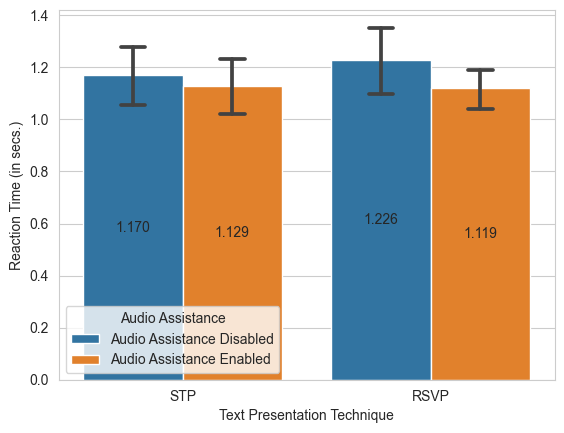

In [66]:
# Restructuring the data frame.
rt_refined = pd.DataFrame(columns = ["Participant_ID", "TPT", "Audio Assistance", "RT"])
rt_refined["RT"] = rt_refined["RT"].astype(float)

 # Manipulate the below variable to remove the zero reaction time values. True: remove, False: Dont remove.
remove_special_values = False

for participant in rt_df["Participant_ID"].unique():
    # NOTE: Try-Catch is required as a data point may have been removed earlier if there was a major collision.
    p_data = rt_df[(rt_df["Participant_ID"] == participant)]
    if remove_special_values:
        try:
            value_1 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["DP0"].values[0]
        except:
            value_1 = 0
        try:
            value_2 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["DP0"].values[1]
        except:
            value_2 = 0

        if (value_1 == 0 or value_2 == 0):
            print("WARNING: 0 value removed.")
            value = value_1 + value_2
            value = Nan if value == 0 else value
        else:
            value = (value_1 + value_2)/2
        new_arr_1 = [participant, "RSVP", "NAA", value]

        try:
            value_1 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["DP0"].values[0]
        except:
            value_1 = 0
        try:
            value_2 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["DP0"].values[1]
        except:
            value_2 = 0

        if (value_1 == 0 or value_2 == 0):
            print("WARNING: 0 value removed.")
            value = value_1 + value_2
            value = Nan if value == 0 else value
        else:
            value = (value_1 + value_2)/2
        new_arr_2 = [participant, "RSVP", "AA", value]

        try:
            value_1 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values[0]
        except:
            value_1 = 0
        try:
            value_2 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values[1]
        except:
            value_2 = 0

        if (value_1 == 0 or value_2 == 0):
            print("WARNING: 0 value removed.")
            value = value_1 + value_2
            value = Nan if value == 0 else value
        else:
            value = (value_1 + value_2)/2
        new_arr_3 = [participant, "STP", "NAA", value]

        try:
            value_1 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)]["DP0"].values[0]
        except:
            value_1 = 0
        try:
            value_2 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)]["DP0"].values[1]
        except:
            value_2 = 0

        if (value_1 == 0 or value_2 == 0):
            print("WARNING: 0 value removed.")
            value = value_1 + value_2
            value = Nan if value == 0 else value
        else:
            value = (value_1 + value_2)/2
        new_arr_4 = [participant, "STP", "AA", value]
    else:
        new_arr_1 = [participant, "RSVP", "NAA",  p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["DP0"].values.mean()]
        new_arr_2 = [participant, "RSVP", "AA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["DP0"].values.mean()]
        new_arr_3 = [participant, "STP", "NAA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values.mean()]
        new_arr_4 = [participant, "STP", "AA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values.mean()]
    
    rt_refined.loc[len(rt_refined)] = new_arr_1
    rt_refined.loc[len(rt_refined)] = new_arr_2
    rt_refined.loc[len(rt_refined)] = new_arr_3
    rt_refined.loc[len(rt_refined)] = new_arr_4

    
# Combine columns TPT and Audio Assistance
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_refined["TPT"].values + rt_refined["Audio Assistance"].values
rt_combined["Reaction Time (in secs.)"] = rt_refined["RT"].values
# Removing the outliers from the data frame
remove_outliers(rt_combined, "Reaction Time (in secs.)")

# Undersampling the data set
rus = RandomUnderSampler(random_state=50)
rt_combined_c2, rt_combined_c1 = rus.fit_resample(rt_combined["Reaction Time (in secs.)"].values.reshape((-1, 1)), rt_combined["TPTAA"].astype(str))
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_combined_c1
rt_combined["Reaction Time (in secs.)"] = rt_combined_c2.astype(float)

# Creating sperate arrays for analysis
rt_stp = rt_combined[rt_combined["TPTAA"] == "STPNAA"]["Reaction Time (in secs.)"].values
rt_stpa = rt_combined[rt_combined["TPTAA"] == "STPAA"]["Reaction Time (in secs.)"].values
rt_rsvp = rt_combined[rt_combined["TPTAA"] == "RSVPNAA"]["Reaction Time (in secs.)"].values
rt_rsvpa = rt_combined[rt_combined["TPTAA"] == "RSVPAA"]["Reaction Time (in secs.)"].values

# Test if the distribution is normal.
print("Shapiro Test for RT_stp; p-value: ", stats.shapiro(rt_stp)[1])
print("Shapiro Test for RT_rsvp; p-value: ", stats.shapiro(rt_rsvp)[1])
print("Shapiro Test for RT_stpa; p-value: ", stats.shapiro(rt_stpa)[1])
print("Shapiro Test for RT_rsvpa; p-value: ", stats.shapiro(rt_rsvpa)[1])

# Perform P-tests for testing the alternate hypothesis
print("=== Testing: RSVP RT < STP RT ===")
# Test if H_a: RT_rsvp < RT_stp
print("H_a: RT_rsvp = RT_stp ; H_a: RT_rsvp < RT_stp")
print(stats.ttest_rel(a = rt_rsvp, b = rt_stp, alternative = "less"))
print("H_a: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa < RT_stpa")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_stpa, alternative = "less"))
# Test if H_a: RT_aae < RT_aad
print("H_a: RT_aae = RT_aad ; H_a: RT_rsvpa < RT_rsvp for RSVP")
print(stats.ttest_rel(a = rt_rsvp, b = rt_rsvpa, alternative = "less"))
print("H_a: RT_aae = RT_aad ; H_a: RT_aae < RT_aad for STP")
print(stats.ttest_rel(a = rt_stp, b = rt_stpa, alternative = "less"))

print("=== Testing: RSVP RT > STP RT ===")
# Test if H_a: RT_rsvp > RT_stp
print("H_a: RT_rsvp = RT_stp ; H_a: RT_rsvp > RT_stp")
print(stats.ttest_rel(a = rt_rsvp, b = rt_stp, alternative = "greater"))
print("H_a: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa > RT_stpa")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_stpa, alternative = "greater"))
# Test if H_a: RT_aae > RT_aad
print("H_a: RT_aae = RT_aad ; H_a: RT_aae > RT_aad for RSVP")
print(stats.ttest_rel(a = rt_rsvp, b = rt_rsvpa, alternative = "greater"))
print("H_a: RT_aae = RT_aad ; H_a: RT_aae > RT_aad for STP")
print(stats.ttest_rel(a = rt_stp, b = rt_stpa, alternative = "less"))

    
# Getting decoupled dataframe for the graph
rt_decoupled = decouple_df(rt_combined)
plot = sns.barplot(data=rt_decoupled, x="Text Presentation Technique", y="Reaction Time (in secs.)", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.3f', label_type='center')

Shapiro Test for alpo_stp; p-value: 0.9912897944450378
Shapiro Test for alpo_rsvp; p-value: 0.8441354632377625
Shapiro Test for alpo_stpa; p-value: 0.7268760800361633
Shapiro Test for alpo_rsvpa; p-value: 0.951298177242279 

=== Testing: RSVP ALPO < STP ALPO ===
H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp < alpo_stp
Ttest_relResult(statistic=-1.9157251417792778, pvalue=0.035286233288918625)
H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa < alpo_stpa
Ttest_relResult(statistic=0.7533413312075578, pvalue=0.7697606553340856)
H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa < alpo_rsvp
Ttest_relResult(statistic=2.3978793299506673, pvalue=0.9865382328654129)
H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa < alpo_stp
Ttest_relResult(statistic=-0.10361055058781123, pvalue=0.4592821256664664)
=== Testing: RSVP ALPO > STP ALPO ===
H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp > alpo_stp
Ttest_relResult(statistic=-1.9157251417792778, pvalue=0.9647137667110814)
H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa > al

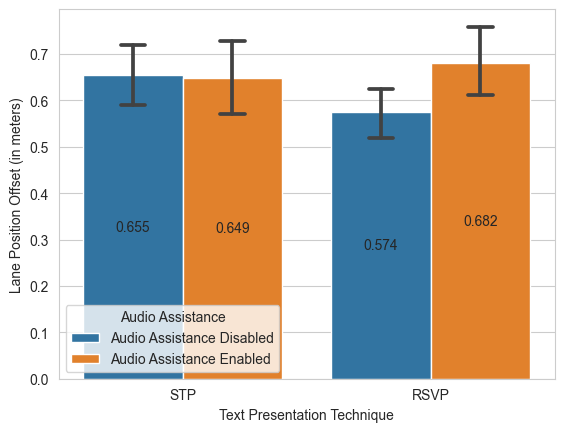

In [58]:
# Analyzing the Average Lane Position Offset.
avg_lane_offsets = []
for i in range(0, lpd_df.shape[0]):
    dp_array = [dp for dp in lpd_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    avg_lane_offsets.append(sum(dp_array)/len(dp_array))
lpd_df["AVG"] = avg_lane_offsets

# Restructuring the data frame.
lpd_refined = pd.DataFrame(columns = ["Participant_ID", "TPT", "Audio Assistance", "LPO"])
lpd_refined["LPO"] = lpd_refined["LPO"].astype(float)

for participant in lpd_df["Participant_ID"].unique():
    p_data = lpd_df[(lpd_df["Participant_ID"] == participant)]
    new_arr_1 = [participant, "RSVP", "NAA",  p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["AVG"].values.mean()]
    new_arr_2 = [participant, "RSVP", "AA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["AVG"].values.mean()]
    new_arr_3 = [participant, "STP", "NAA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["AVG"].values.mean()]
    new_arr_4 = [participant, "STP", "AA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["AVG"].values.mean()]
    
    lpd_refined.loc[len(lpd_refined)] = new_arr_1
    lpd_refined.loc[len(lpd_refined)] = new_arr_2
    lpd_refined.loc[len(lpd_refined)] = new_arr_3
    lpd_refined.loc[len(lpd_refined)] = new_arr_4

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Lane Position Offset (in meters)"] = lpd_refined["LPO"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Lane Position Offset (in meters)")

# Undersampling the data set
rus = RandomUnderSampler(random_state=50)
lpd_combined_c2, lpd_combined_c1 = rus.fit_resample(lpd_combined["Lane Position Offset (in meters)"].values.reshape((-1, 1)), lpd_combined["TPTAA"].astype(str))
lpd_combined = pd.DataFrame()
lpd_combined["TPTAA"] = lpd_combined_c1
lpd_combined["Lane Position Offset (in meters)"] = lpd_combined_c2.astype(float)

# Creating separate arrays for analysis
alpo_stp = lpd_combined[lpd_combined["TPTAA"] == "STPNAA"]["Lane Position Offset (in meters)"].values
alpo_stpa = lpd_combined[lpd_combined["TPTAA"] == "STPAA"]["Lane Position Offset (in meters)"].values
alpo_rsvp = lpd_combined[lpd_combined["TPTAA"] == "RSVPNAA"]["Lane Position Offset (in meters)"].values
alpo_rsvpa = lpd_combined[lpd_combined["TPTAA"] == "RSVPAA"]["Lane Position Offset (in meters)"].values

# Test is the distribution is normal.
print("Shapiro Test for alpo_stp; p-value:", stats.shapiro(alpo_stp)[1])
print("Shapiro Test for alpo_rsvp; p-value:", stats.shapiro(alpo_rsvp)[1])
print("Shapiro Test for alpo_stpa; p-value:", stats.shapiro(alpo_stpa)[1])
print("Shapiro Test for alpo_rsvpa; p-value:", stats.shapiro(alpo_rsvpa)[1], "\n")

# Perform P-tests for testing the hypothesis

print("=== Testing: RSVP ALPO < STP ALPO ===")
# Test if H_a: alpo_rsvp < alpo
print("H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp < alpo_stp")
print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "less"))
print("H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa < alpo_stpa")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "less"))
# Test if H_a: alpo_aae < alpo_aad
print("H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa < alpo_rsvp")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "less"))
print("H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa < alpo_stp")
print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "less"))

print("=== Testing: RSVP ALPO > STP ALPO ===")
# Test if H_a: alpo_rsvp > alpo_stp
print("H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp > alpo_stp")
print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "greater"))
print("H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa > alpo_stpa")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "greater"))
# Test if H_a: alpo_aae > alpo_aad
print("H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa > alpo_rsvp")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "greater"))
print("H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa > alpo_stp")
print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "greater"))

# Getting decoupled dataframe for the graph
lpd_decoupled = decouple_df(lpd_combined)
plot = sns.barplot(data=lpd_decoupled, x="Text Presentation Technique", y="Lane Position Offset (in meters)", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.3f', label_type='center')

Shapiro Test for msav_stp; p-value: 0.3399166464805603
Shapiro Test for msav_rsvp; p-value: 0.7029961943626404
Shapiro Test for msav_stpa; p-value: 0.33191919326782227
Shapiro Test for msav_rsvpa; p-value: 0.6082281470298767 

=== Testing: RSVP MSAV < STP MSAV ===
H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp < msav_stp
Ttest_relResult(statistic=-0.9142105476348914, pvalue=0.185748427911829)

H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa < msav_stpa
Ttest_relResult(statistic=-1.1424103752525956, pvalue=0.1333880300872066)

H_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa < msav_rsvp
Ttest_relResult(statistic=-0.6026694947369199, pvalue=0.27675070795425805)

H_0: msav_stpa = msav_stp ; H_a: msav_stpa < msav_stp
Ttest_relResult(statistic=-0.35811209762811697, pvalue=0.36200568015089707)
=== Testing: RSVP MSAV > STP MSAV ===

H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp > msav_stp
Ttest_relResult(statistic=-0.9142105476348914, pvalue=0.814251572088171)

H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsv

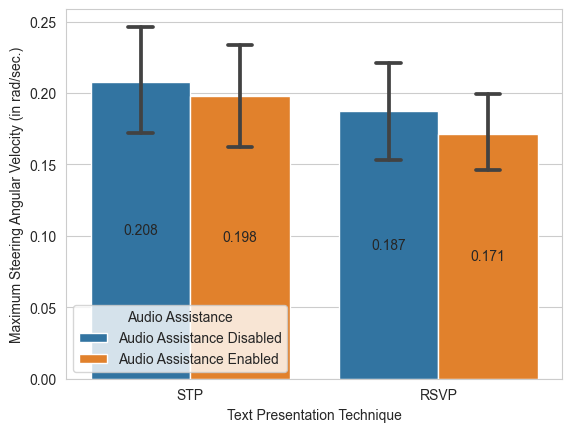

In [60]:
# Analyzing the Maximum Steering Angle Velocity
MSVs = []
for i in range(0, swv_df.shape[0]):
    dp_array = [dp for dp in swv_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MSVs.append(max(dp_array))
swv_df["MAX"] = MSVs

# Restructuring the data frame.
msav_refined = pd.DataFrame(columns = ["Participant_ID", "TPT", "Audio Assistance", "MSAV"])
msav_refined["MSAV"] = msav_refined["MSAV"].astype(float)

for participant in swv_df["Participant_ID"].unique():
    p_data = swv_df[(swv_df["Participant_ID"] == participant)]
    new_arr_1 = [participant, "RSVP", "NAA",  p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["MAX"].values.mean()]
    new_arr_2 = [participant, "RSVP", "AA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["MAX"].values.mean()]
    new_arr_3 = [participant, "STP", "NAA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["MAX"].values.mean()]
    new_arr_4 = [participant, "STP", "AA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["MAX"].values.mean()]

    msav_refined.loc[len(msav_refined)] = new_arr_1
    msav_refined.loc[len(msav_refined)] = new_arr_2
    msav_refined.loc[len(msav_refined)] = new_arr_3
    msav_refined.loc[len(msav_refined)] = new_arr_4

# Combine columns TPT and Audio Assistance
msav_combined = pd.DataFrame()
msav_combined["TPTAA"] = msav_refined["TPT"].values + msav_refined["Audio Assistance"].values
msav_combined["Maximum Steering Angular Velocity (in rad/sec.)"] = msav_refined["MSAV"].values

# Removing the outliers from the data frame
remove_outliers(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Undersampling the data set
rus = RandomUnderSampler(random_state=50)
msav_combined_c2, msav_combined_c1 = rus.fit_resample(msav_combined["Maximum Steering Angular Velocity (in rad/sec.)"].values.reshape((-1, 1)), msav_combined["TPTAA"].astype(str))
msav_combined = pd.DataFrame()
msav_combined["TPTAA"] = msav_combined_c1
msav_combined["Maximum Steering Angular Velocity (in rad/sec.)"] = msav_combined_c2.astype(float)

# Creating separate arrays for analysis
msav_stp = msav_combined[msav_combined["TPTAA"] == "STPNAA"]["Maximum Steering Angular Velocity (in rad/sec.)"].values
msav_stpa = msav_combined[msav_combined["TPTAA"] == "STPAA"]["Maximum Steering Angular Velocity (in rad/sec.)"].values
msav_rsvp = msav_combined[msav_combined["TPTAA"] == "RSVPNAA"]["Maximum Steering Angular Velocity (in rad/sec.)"].values
msav_rsvpa = msav_combined[msav_combined["TPTAA"] == "RSVPAA"]["Maximum Steering Angular Velocity (in rad/sec.)"].values

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for msav_stp; p-value:", stats.shapiro(msav_stp)[1])
print("Shapiro Test for msav_rsvp; p-value:", stats.shapiro(msav_rsvp)[1])
print("Shapiro Test for msav_stpa; p-value:", stats.shapiro(msav_stpa)[1])
print("Shapiro Test for msav_rsvpa; p-value:", stats.shapiro(msav_rsvpa)[1], "\n")

# Perform P-tests for testing the alternate hypothesis

print("=== Testing: RSVP MSAV < STP MSAV ===")
# Test if H_a: msav_rsvp < msav_stp
print("H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp < msav_stp")
print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "less"))
print("\nH_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa < msav_stpa")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "less"))
# Test if H_a: msav_aae < msav_aad
print("\nH_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa < msav_rsvp")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "less"))
print("\nH_0: msav_stpa = msav_stp ; H_a: msav_stpa < msav_stp")
print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "less"))

print("=== Testing: RSVP MSAV > STP MSAV ===")
# Test if H_a: msav_rsvp > msav_stp
print("\nH_0: msav_rsvp = msav_stp ; H_a: msav_rsvp > msav_stp")
print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "greater"))
print("\nH_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa > msav_stpa")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "greater"))
# Test if H_a: msav_aae > msav_aad
print("\nH_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa > msav_rsvp")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "greater"))
print("\nH_0: msav_stpa = msav_stp ; H_a: msav_stpa > msav_stp")
print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "greater"))

# Getting decoupled dataframe for the graph
msav_decoupled = decouple_df(msav_combined)
plot = sns.barplot(data=msav_decoupled, x="Text Presentation Technique", y="Maximum Steering Angular Velocity (in rad/sec.)", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.3f', label_type='center')

Shapiro Test for sdswa_stp; p-value: 0.038838647305965424
Shapiro Test for sdswa_rsvp; p-value: 0.25259026885032654
Shapiro Test for sdswa_stpa; p-value: 0.04764948785305023
Shapiro Test for sdswa_rsvpa; p-value: 0.00039853560156188905 

Test: SDSWA_rsvp < SDSWA_stp [p value: 0.41729449357097753]
Test: SDSWA_rsvpa < SDSWA_stpa [p value: 0.9954803071726904]
Test: SDSWA_rsvpa < SDSWA_rsvp [p value: 0.9819241139096563]
Test: SDSWA_stpa < SDSWA_stp [p value: 0.36672001142369093]
    TPT          AA Disabled           AA Enabled
0   STP  0.31598273843178454   0.3025497095575963
1  RSVP   0.3135096379030997  0.38622330467069993


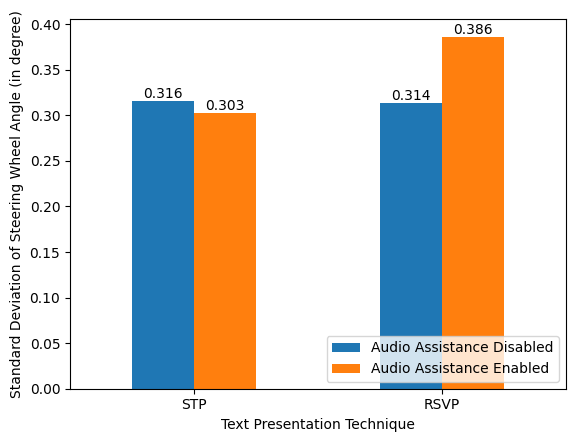

In [12]:
# Analyzing the Standard Deviation of Steering Wheel Angle
SDSWAs = []
for i in range(0, swa_df.shape[0]):
    dp_array = [dp for dp in swa_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SDSWAs.append(np.std(dp_array))
swa_df["SD"] = SDSWAs

# Create seperate arrays for 2 x 2 cases
sdswa_stp = swa_df[(swa_df["RSVP"] == 0) & (swa_df["TTS"] == 0)]["SD"].values
sdswa_stpa = swa_df[(swa_df["RSVP"] == 0) & (swa_df["TTS"] == 1)]["SD"].values
sdswa_rsvp = swa_df[(lpd_df["RSVP"] == 1) & (swa_df["TTS"] == 0)]["SD"].values
sdswa_rsvpa = swa_df[(lpd_df["RSVP"] == 1) & (swa_df["TTS"] == 1)]["SD"].values

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for sdswa_stp; p-value:", stats.shapiro(sdswa_stp)[1])
print("Shapiro Test for sdswa_rsvp; p-value:", stats.shapiro(sdswa_rsvp)[1])
print("Shapiro Test for sdswa_stpa; p-value:", stats.shapiro(sdswa_stpa)[1])
print("Shapiro Test for sdswa_rsvpa; p-value:", stats.shapiro(sdswa_rsvpa)[1], "\n")
# Test is the distribution is normal.

data_is_normal = False

if data_is_normal:
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: sdswa_rsvp < sdswa_stp
    print("H_0: sdswa_rsvp = sdswa_stp ; H_a: sdswa_rsvp < sdswa_stp")
    print(stats.ttest_rel(a = sdswa_rsvp, b = sdswa_stp, alternative = "less"))
    print("\nH_0: sdswa_rsvpa = sdswa_stpa ; H_a: sdswa_rsvpa < sdswa_stpa")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_stpa, alternative = "less"))

    # Test if H_a: sdswa_aae < sdswa_aad
    print("\nH_0: sdswa_rsvpa = sdswa_rsvp ; H_a: sdswa_rsvpa < sdswa_rsvp")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_rsvp, alternative = "less"))
    print("\nH_0: sdswa_stpa = sdswa_stp ; H_a: sdswa_stpa < sdswa_stp")
    print(stats.ttest_rel(a = sdswa_stpa, b = sdswa_stp, alternative = "less"))

    # Test if H_a: sdswa_rsvp > sdswa_stp
    print("\nH_0: sdswa_rsvp = sdswa_stp ; H_a: sdswa_rsvp > sdswa_stp")
    print(stats.ttest_rel(a = sdswa_rsvp, b = sdswa_stp, alternative = "greater"))
    print("\nH_0: sdswa_rsvpa = sdswa_stpa ; H_a: sdswa_rsvpa > sdswa_stpa")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_stpa, alternative = "greater"))

    # Test if H_a: sdswa_aae > sdswa_aad
    print("\nH_0: sdswa_rsvpa = sdswa_rsvp ; H_a: sdswa_rsvpa > sdswa_rsvp")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_rsvp, alternative = "greater"))
    print("\nH_0: sdswa_stpa = sdswa_stp ; H_a: sdswa_stpa > sdswa_stp")
    print(stats.ttest_rel(a = sdswa_stpa, b = sdswa_stp, alternative = "greater"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(sdswa_rsvp, sdswa_stp, alternative='less')
    print("Test: SDSWA_rsvp < SDSWA_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(sdswa_rsvpa, sdswa_stpa, alternative='less')
    print("Test: SDSWA_rsvpa < SDSWA_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(sdswa_rsvpa, sdswa_rsvp, alternative='less')
    print("Test: SDSWA_rsvpa < SDSWA_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(sdswa_stpa, sdswa_stp, alternative='less')
    print("Test: SDSWA_stpa < SDSWA_stp [p value: {}]".format(p4))

# CONCLUSION:
# No significant difference was observed

# Generating data frame for SDSWA results
sdswa_results_array = np.array([
    ["STP",np.mean(sdswa_stp), np.mean(sdswa_stpa)],
    ["RSVP",np.mean(sdswa_rsvp), np.mean(sdswa_rsvpa)],
])
sdswa_results_df = pd.DataFrame(sdswa_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(sdswa_results_df)

# Converting the column types
sdswa_results_df["TPT"] = sdswa_results_df["TPT"].astype(str)
sdswa_results_df["AA Disabled"] = sdswa_results_df["AA Disabled"].astype(float)
sdswa_results_df["AA Enabled"] = sdswa_results_df["AA Enabled"].astype(float)

# Plotting paired bar graph
bplot = sdswa_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Standard Deviation of Steering Wheel Angle (in degree)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

    TPT          AA Disabled           AA Enabled
0   STP   0.3305022161033627   0.3166876773701221
1  RSVP  0.36011938584136893  0.33387420409331797
Shapiro Test for BIR_stp; p-value:  0.12854142487049103
Shapiro Test for BIR_rsvp; p-value:  0.081064373254776
Shapiro Test for BIR_stpa; p-value:  0.24619744718074799
Shapiro Test for BIR_rsvpa; p-value:  0.014848645776510239
Test: BIR_rsvp < BIR_stp [p value: 0.8392339700898409]
Test: BIR_rsvpa < BIR_stpa [p value: 0.8011737054652608]
Test: BIR_rsvpa < BIR_rsvp [p value: 0.31075202603008467]
Test: BIR_stpa < BIR_stp [p value: 0.35433608415953954]


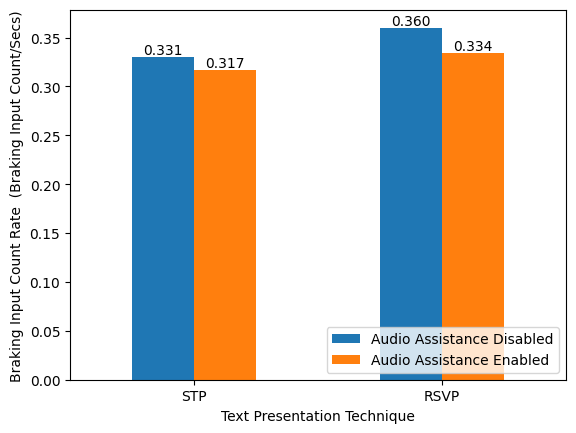

In [13]:
# Analysing the Breaking Input Rate
BIRs = []
for i in range(0, bi_df.shape[0]):
    dp_array = [dp for dp in bi_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    for value in dp_array:
        if value != 0:
            count += 1
    rate = float(count)/len(dp_array)
    BIRs.append(rate)
bi_df["RATE"] = BIRs

# Create seperate arrays for 2 x 2 cases
bir_stp = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 0)]["RATE"].values
bir_stpa = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 1)]["RATE"].values
bir_rsvp = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 0)]["RATE"].values
bir_rsvpa = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 1)]["RATE"].values

bir_results_array = np.array([
    ["STP",np.mean(bir_stp), np.mean(bir_stpa)],
    ["RSVP",np.mean(bir_rsvp), np.mean(bir_rsvpa)],
])

bir_results_df = pd.DataFrame(bir_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(bir_results_df)

# Converting the column types
bir_results_df["TPT"] = bir_results_df["TPT"].astype(str)
bir_results_df["AA Disabled"] = bir_results_df["AA Disabled"].astype(float)
bir_results_df["AA Enabled"] = bir_results_df["AA Enabled"].astype(float)


# Test if the distribution is normal.
print("Shapiro Test for BIR_stp; p-value: ", stats.shapiro(bir_stp)[1])
print("Shapiro Test for BIR_rsvp; p-value: ", stats.shapiro(bir_rsvp)[1])
print("Shapiro Test for BIR_stpa; p-value: ", stats.shapiro(bir_stpa)[1])
print("Shapiro Test for BIR_rsvpa; p-value: ", stats.shapiro(bir_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: BIR_rsvp < BIR_stp
    print("H_a: BIR_rsvp = BIR_stp ; H_a: BIR_rsvp < BIR_stp")
    print(stats.ttest_rel(a = bir_rsvp, b = bir_stp, alternative = "less"))
    print("H_a: BIR_rsvpa = BIR_stpa ; H_a: BIR_rsvpa < BIR_stpa")
    print(stats.ttest_rel(a = bir_rsvpa, b = bir_stpa, alternative = "less"))

    # Test if H_a: BIR_aae < BIR_aad
    print("H_a: BIR_aae = BIR_aad ; H_a: BIR_aae < BIR_aad for RSVP")
    print(stats.ttest_rel(a = bir_rsvp, b = bir_rsvpa, alternative = "less"))
    print("H_a: BIR_aae = BIR_aad ; H_a: BIR_aae < BIR_aad for STP")
    print(stats.ttest_rel(a = bir_stp, b = bir_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(bir_rsvp, bir_stp, alternative='less')
    print("Test: BIR_rsvp < BIR_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(bir_rsvpa, bir_stpa, alternative='less')
    print("Test: BIR_rsvpa < BIR_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(bir_rsvpa, bir_rsvp, alternative='less')
    print("Test: BIR_rsvpa < BIR_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(bir_stpa, bir_stp, alternative='less')
    print("Test: BIR_stpa < BIR_stp [p value: {}]".format(p4))

bplot = bir_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Braking Input Count Rate  (Braking Input Count/Secs)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

    TPT         AA Disabled           AA Enabled
0   STP  0.3357795333333334   0.3109251136363636
1  RSVP  0.2986834666666666  0.29346683720930233
Shapiro Test for MBI_stp; p-value:  0.00040667629218660295
Shapiro Test for MBI_rsvp; p-value:  0.016244124621152878
Shapiro Test for MBI_stpa; p-value:  0.002442239550873637
Shapiro Test for MBI_rsvpa; p-value:  0.002740544732660055
Test: MBI_rsvp < MBI_stp [p value: 0.1339439340827278]
Test: MBI_rsvpa < MBI_stpa [p value: 0.3813985241436723]
Test: MBI_rsvpa < MBI_rsvp [p value: 0.3944223774740956]
Test: MBI_stpa < MBI_stp [p value: 0.54740213991856]


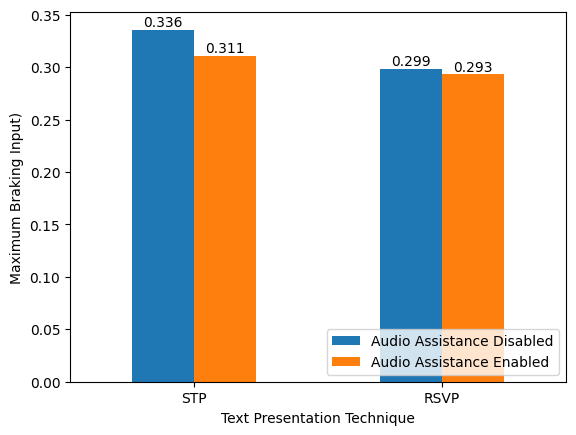

In [8]:
# Analysing the Maximum breaking input
MBIs = []
for i in range(0, bi_df.shape[0]):
    dp_array = [dp for dp in bi_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MBIs.append(max(dp_array))
bi_df["MAX"] = MBIs

# Create seperate arrays for 2 x 2 cases
mbi_stp = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_stpa = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 1)]["MAX"].values
mbi_rsvp = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_rsvpa = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 1)]["MAX"].values

mbi_results_array = np.array([
    ["STP",np.mean(mbi_stp), np.mean(mbi_stpa)],
    ["RSVP",np.mean(mbi_rsvp), np.mean(mbi_rsvpa)],
])

mbi_results_df = pd.DataFrame(mbi_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(mbi_results_df)

# Converting the column types
mbi_results_df["TPT"] = mbi_results_df["TPT"].astype(str)
mbi_results_df["AA Disabled"] = mbi_results_df["AA Disabled"].astype(float)
mbi_results_df["AA Enabled"] = mbi_results_df["AA Enabled"].astype(float)


# Test if the distribution is normal.
print("Shapiro Test for MBI_stp; p-value: ", stats.shapiro(mbi_stp)[1])
print("Shapiro Test for MBI_rsvp; p-value: ", stats.shapiro(mbi_rsvp)[1])
print("Shapiro Test for MBI_stpa; p-value: ", stats.shapiro(mbi_stpa)[1])
print("Shapiro Test for MBI_rsvpa; p-value: ", stats.shapiro(mbi_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: MBI_rsvp < MBI_stp
    print("H_a: MBI_rsvp = MBI_stp ; H_a: MBI_rsvp < MBI_stp")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_stp, alternative = "less"))
    print("H_a: MBI_rsvpa = MBI_stpa ; H_a: MBI_rsvpa < MBI_stpa")
    print(stats.ttest_rel(a = mbi_rsvpa, b = mbi_stpa, alternative = "less"))

    # Test if H_a: MBI_aae < MBI_aad
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for RSVP")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_rsvpa, alternative = "less"))
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for STP")
    print(stats.ttest_rel(a = mbi_stp, b = mbi_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(mbi_rsvp, mbi_stp, alternative='less')
    print("Test: MBI_rsvp < MBI_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(mbi_rsvpa, mbi_stpa, alternative='less')
    print("Test: MBI_rsvpa < MBI_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(mbi_rsvpa, mbi_rsvp, alternative='less')
    print("Test: MBI_rsvpa < MBI_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(mbi_stpa, mbi_stp, alternative='less')
    print("Test: MBI_stpa < MBI_stp [p value: {}]".format(p4))

bplot = mbi_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Maximum Braking Input)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

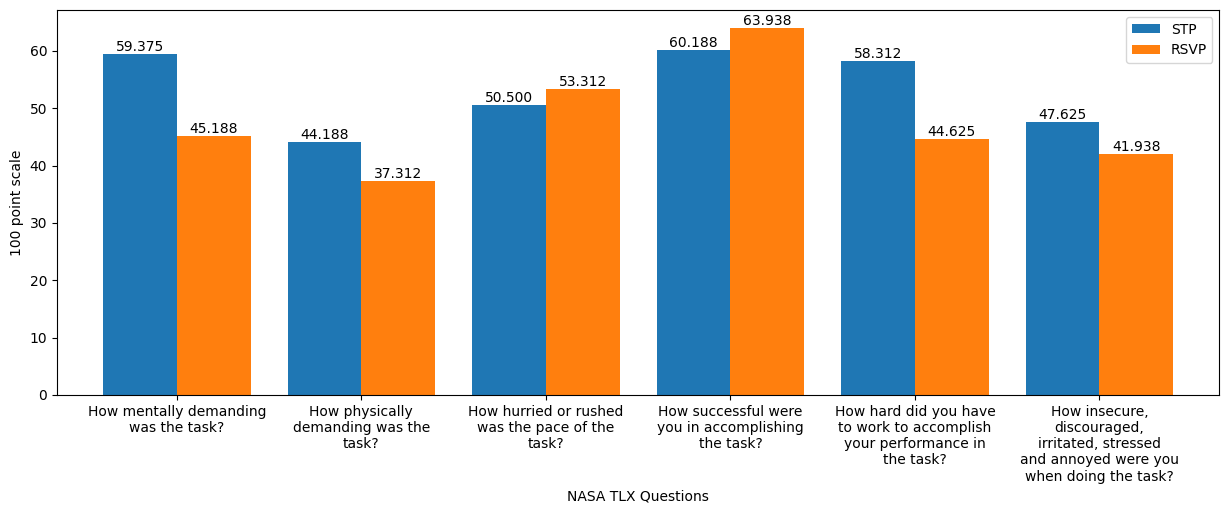

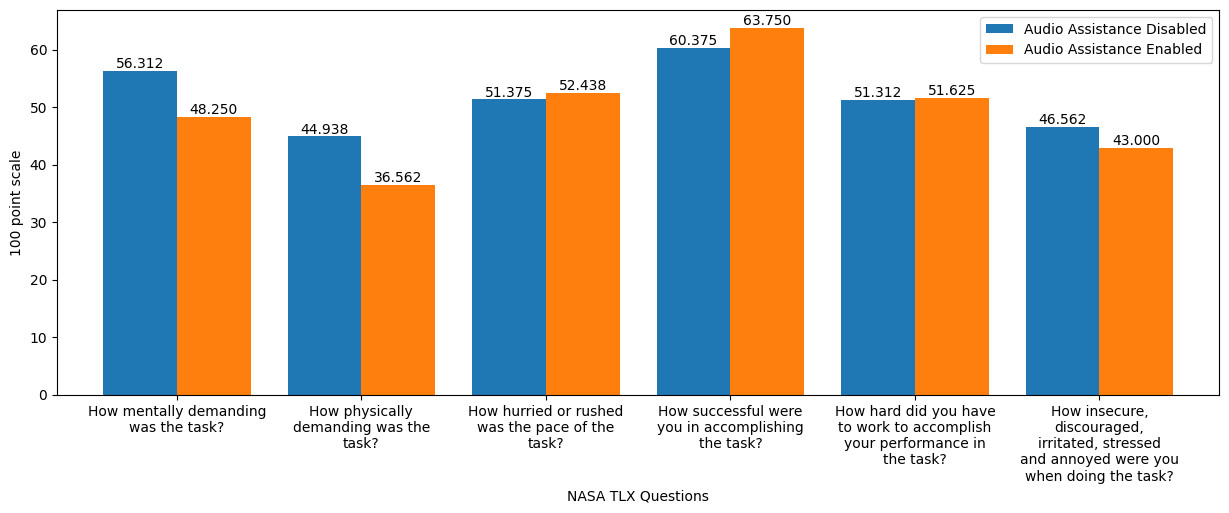

In [15]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Diplay
# Q3: Text Presentation Technique
# Q4_1 How mentally demanding was the task?
# Q4_2: How physically demanding was the task?
# Q4_3: How hurried or rushed was the pace of the task?
# Q4_4: How successful were you in accomplishing the task?
# Q4_5: How hard did you have to work to accomplish your performance in the task?
# Q4_6: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?
axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
labels = []
for label in axis_labels:
    labels.append(textwrap.fill(label, width=22,
                  break_long_words=False))

nasa_tlx_stp = nasa_tlx[nasa_tlx["Q3"] == "STP"]
nasa_tlx_rsvp = nasa_tlx[nasa_tlx["Q3"] == "RSVP"]
nasa_tlx_aae = nasa_tlx[nasa_tlx["Q2"] == "HUDAA"]
nasa_tlx_aad = nasa_tlx[nasa_tlx["Q2"] == "HUD"]

TPT_diff = np.array([
    ["Q1", np.mean(nasa_tlx_stp["Q4_1"]), np.mean(nasa_tlx_rsvp["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_stp["Q4_2"]), np.mean(nasa_tlx_rsvp["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_stp["Q4_3"]), np.mean(nasa_tlx_rsvp["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_stp["Q4_4"]), np.mean(nasa_tlx_rsvp["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_stp["Q4_5"]), np.mean(nasa_tlx_rsvp["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_stp["Q4_6"]), np.mean(nasa_tlx_rsvp["Q4_6"])],

])

AA_diff = np.array([
    ["Q1", np.mean(nasa_tlx_aad["Q4_1"]), np.mean(nasa_tlx_aae["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_aad["Q4_2"]), np.mean(nasa_tlx_aae["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_aad["Q4_3"]), np.mean(nasa_tlx_aae["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_aad["Q4_4"]), np.mean(nasa_tlx_aae["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_aad["Q4_5"]), np.mean(nasa_tlx_aae["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_aad["Q4_6"]), np.mean(nasa_tlx_aae["Q4_6"])],
])

nasa_tlx_tpt_df = pd.DataFrame(TPT_diff, columns = ["Question", "STP", "RSVP"])
nasa_tlx_aa_df = pd.DataFrame(AA_diff, columns = ["Question", "AAD", "AAE"])

# Converting the column types
nasa_tlx_tpt_df["Question"] = nasa_tlx_tpt_df["Question"].astype(str)
nasa_tlx_tpt_df["STP"] = nasa_tlx_tpt_df["STP"].astype(float)
nasa_tlx_tpt_df["RSVP"] = nasa_tlx_tpt_df["RSVP"].astype(float)

nasa_tlx_aa_df["Question"] = nasa_tlx_aa_df["Question"].astype(str)
nasa_tlx_aa_df["AAD"] = nasa_tlx_aa_df["AAD"].astype(float)
nasa_tlx_aa_df["AAE"] = nasa_tlx_aa_df["AAE"].astype(float)
                                                  
# RSVP vs STP
bplot = nasa_tlx_tpt_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))

bplot.set_xticklabels(labels, rotation=0)

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')
    
# Audio assistance disabled vs audio assistance enabled
bplot2 = nasa_tlx_aa_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))
bplot2.set_xticklabels(labels, rotation=0)
bplot2.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"])

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot2.containers:
    bplot2.bar_label(p, fmt='%.3f', label_type='edge')

,Participant_ID,TPT,Audio Assistance,Accuracy
0,P06,STP,NAA,90.000000
1,P06,STP,AA,30.000000
2,P06,RSVP,NAA,70.833333
3,P06,RSVP,AA,30.000000
4,P07,STP,NAA,100.000000
5,P07,STP,AA,80.000000
6,P07,RSVP,NAA,90.000000
7,P07,RSVP,AA,91.666667
8,P08,STP,NAA,87.500000
9,P08,STP,AA,90.000000


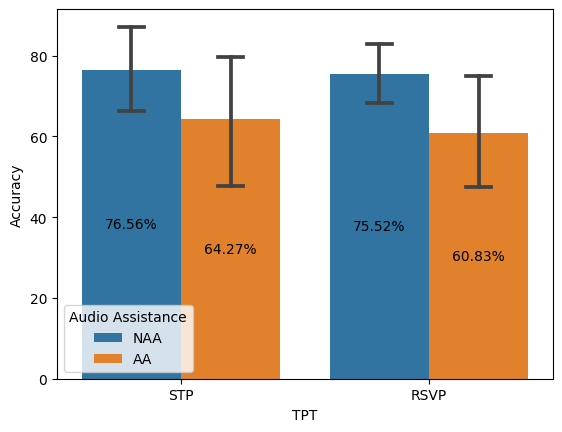

In [42]:
correct_answers = [1, 2, 3, 4, 2, 1, 3, 2, 4, 2, 4, 2, 3, 3, 4, 1, 2, 1, 3, 2, 1, 3, 4, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2, 1, 4, 4, 4, 2]
acc_col = []
for i in range(0, comp_test_df.shape[0]):
    row = [dp for dp in comp_test_df.iloc[i].values.tolist()[4:]]
    correct = 0
    incorrect = 0
    for j in range(0, len(correct_answers)):
        if not math.isnan(row[j]):
            if row[j] == correct_answers[j]:
                correct += 1
            else:
                incorrect += 1
    acc_col.append(float(correct)/(correct+incorrect))

comp_test_acc_df = pd.DataFrame().assign(Participant_ID=comp_test_df['Q1'], AA=comp_test_df['Qa'], TPT=comp_test_df['Qb'], TF=comp_test_df['Qc'])
comp_test_acc_df['Accuracy']= acc_col
# AA = 1 If Enabled, 2 If Disabled
# TPT = 1 If STP, 2 If RSVP
# TF ranges between 1-8

# Creating a dataframe to plot the data
comp_test_refined_df = pd.DataFrame(columns=['Participant_ID', 'TPT', 'Audio Assistance', 'Accuracy'])
comp_test_refined_df["Accuracy"] = comp_test_refined_df["Accuracy"].astype(float)

for participant in comp_test_acc_df["Participant_ID"].unique():
    # Get the dataframe for the participant
    participant_df = comp_test_acc_df[comp_test_acc_df["Participant_ID"] == participant]
    
    # Get the dataframe for each of the four cases
    df_row_stp = [participant, "STP", "NAA"];
    df_row_rsvp = [participant, "RSVP", "NAA"];
    df_row_stpa = [participant, "STP", "AA"];
    df_row_rsvpa = [participant, "RSVP", "AA"];
    
    # Adding the stp NAA test value
    df_row_stp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the stp AA test value
    df_row_stpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the rsvp NAA test value
    df_row_rsvp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    # Adding the rsvpa AA test value
    df_row_rsvpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    
    # Adding the rows in the dataframe
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stpa
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvpa
    
plot = sns.barplot(data=comp_test_refined_df, x="TPT", y="Accuracy", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.2f%%', label_type='center')
display(comp_test_refined_df)